# Libraries uploading

In [1]:
#basic operations
from typing import Union, Tuple, Optional
import os
from tqdm import tqdm

#data handling 
import segyio

#math core
import numpy as np
from numpy.random import RandomState

import pylops

import scipy
from scipy.sparse import csc_matrix, linalg
from scipy import signal
from scipy.optimize import minimize
from scipy.signal import butter, tukey, filtfilt

#visualization core
import matplotlib.pyplot as plt
import matplotlib.colors

# Defining functions

In [2]:
class Operator:
    """
    A class containing static methods to generate convolution operators for various purposes.
    """
    @staticmethod
    def _convolve_operator(kernel: Union[list, np.ndarray], nt: int, offset: Optional[int] = None) -> np.ndarray:
        """
        Computes the discrete linear convolution operator for two one-dimensional sequences.

        Args:
            kernel (list or np.ndarray): First input array.
            nt (int): Length of the output array after convolution.
            offset (int, optional): Offset (default is half the length of `kernel`).

        Returns:
            np.ndarray: Convolution operator (nt, nt).

        Example:
            >>> kernel = [1, 2, 3]
            >>> nt = 5
            >>> result = convolve_operator(kernel, nt)
            >>> print(result)
            [[2. 3. 0. 0. 0.]
             [1. 2. 3. 0. 0.]
             [0. 1. 2. 3. 0.]
             [0. 0. 1. 2. 3.]
             [0. 0. 0. 1. 2.]]
        """
        try:
            # Calculate the offset if not provided
            offset = len(kernel) // 2 if offset is None else offset

            # Construct the first column and first row for Toeplitz matrix
            first_col, first_row = np.r_[kernel, np.zeros(nt + offset)], np.r_[kernel[0], np.zeros(nt - 1)]

            # Create the Toeplitz matrix and extract the relevant part
            operator = scipy.linalg.toeplitz(first_col, first_row)[offset: offset + nt]

            return operator
        except Exception as e:
            print(f"Error in _convolve_operator: {e}")
            return np.array([])

    @classmethod
    def first_derivative(cls, nt: int, mode: str = "forward") -> np.ndarray:
        """
        Generates a first-order derivative convolution operator.

        Args:
            nt (int): Length of the output array after convolution.

        Returns:
            np.ndarray: First-order derivative convolution operator (nt, nt).
            
        Example:
            >>> nt = 4
            >>> result = first_derivative(nt)
            >>> print(result)
            [[-1.  1.  0.  0.]
             [ 0. -1.  1.  0.]
             [ 0.  0. -1.  1.]
             [ 0.  0.  0.  0.]]
        
        """
        
        try:
            if mode == "forward":
                operator = cls._convolve_operator([1, -1], nt, offset=1)
                operator[-1, :] = 0
            elif mode == "centered":
                operator = cls._convolve_operator([1, 0,-1], nt)
            return operator
        except Exception as e:
            print(f"Error in first_derivative: {e}")
            return np.array([])

    @classmethod
    def second_derivative(cls, nt: int) -> np.ndarray:
        """
        Generates a second-order derivative convolution operator.

        Args:
            nt (int): Length of the output array after convolution.

        Returns:
            np.ndarray: Second-order derivative convolution operator (nt, nt).
        """
        try:
            operator = cls._convolve_operator([-1, 2, -1], nt, offset=2)
            operator[-2:, :] = 0
            return operator
        except Exception as e:
            print(f"Error in second_derivative: {e}")
            return np.array([])

    @classmethod
    def wavelet_operator(cls, wavelet: Union[list, np.ndarray], nt: int) -> np.ndarray:
        """
        Generates a convolution operator using the provided wavelet.

        Args:
            wavelet (list or np.ndarray): Wavelet array.
            nt (int): Length of the output array after convolution.

        Returns:
            np.ndarray: Convolution operator using the provided wavelet (nt, nt).
        """
        try:
            operator = cls._convolve_operator(wavelet, nt)
            return operator
        except Exception as e:
            print(f"Error in wavelet_operator: {e}")
            return np.array([])

    @classmethod
    def acoustic(cls, wavelet: Union[list, np.ndarray], nt: int) -> np.ndarray:
        """
        Computes the acoustic operator (W*D, according to the convolutional model of seismic trace) 
        for a given wavelet and length of the output array.

        Args:
            wavelet (list or np.ndarray): One-dimensional array representing the wavelet.
            nt (int): Length of the output array.

        Returns:
            np.ndarray: Acoustic operator (nt, nt).

        Example:
            >>> wavelet = [1, -1, 2]
            >>> nt = 4
            >>> result = acoustic_operator(wavelet, nt)
            >>> print(result)
            [[-1.  2. -1.  0.]
             [ 2. -3.  2. -1.]
             [ 0.  2. -3.  2.]
             [ 0.  0.  2. -3.]]
        """
        try:
            return cls.wavelet_operator(wavelet, nt) @ cls.first_derivative(nt)
        except Exception as e:
            print(f"Error in acoustic: {e}")
            return np.array([])
    
    @classmethod
    def akirichards(cls, theta: Union[list, np.ndarray], 
                vsvp: Union[float, np.ndarray], nt: int = 2,) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Computes the Aki-Richards approximation for reflection coefficients.

        Args:
            theta (list or np.ndarray): Incident angles in degrees.
            vsvp (float or np.ndarray): Ratio of S-wave velocity to P-wave velocity.
            nt (int, optional): Number of discrete (default is 1).

        Returns:
            Tuple[np.ndarray, np.ndarray, np.ndarray]: Reflection coefficients (G1, G2, G3).

        Example:
            >>> theta_deg = [10, 20, 30]
            >>> vsvp = 0.56
            >>> G1, G2, G3 = akirichards(theta_deg, vsvp)
            >>> print(G1, G2, G3)
        """
        # Convert incident angles to radians
        theta = np.deg2rad(theta) 

        # Ensure vsvp is an array
        vsvp = vsvp * np.ones(nt) if not isinstance(vsvp, np.ndarray) else vsvp  #тернарный оператор для превращения vsvp в массив

        # Compute Aki-Richards coefficients
        G1 = 1.0 / (2.0 * np.cos(theta[:, np.newaxis] ) ** 2) + 0*vsvp
        G2 = -4.0 * vsvp**2 * np.sin(theta[:, np.newaxis] ) ** 2
        G3 = 0.5 - 2.0 * vsvp**2 * np.sin(theta[:, np.newaxis] ) ** 2

        return G1, G2, G3

    @classmethod
    def fatti(cls, theta: Union[list, np.ndarray], 
                vsvp: Union[float, np.ndarray], nt: int = 2,) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        
        theta = np.deg2rad(theta)
        vsvp = vsvp * np.ones(nt) if not isinstance(vsvp, np.ndarray) else vsvp

        G1 = 0.5 * (1 + np.tan(theta[:, np.newaxis]) ** 2) + 0 * vsvp
        G2 = -4.0 * vsvp**2 * np.sin(theta[:, np.newaxis]) ** 2
        G3 = 0.5 * (4 * vsvp**2 * np.sin(theta[:, np.newaxis]) ** 2 - np.tan(theta[:, np.newaxis]) ** 2)

        return G1, G2, G3   

    @classmethod
    def ps(cls, theta: Union[list, np.ndarray], 
                vsvp: Union[float, np.ndarray], nt: int = 2,) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        
        theta = np.deg2rad(theta)
        vsvp = vsvp * np.ones(nt) if not isinstance(vsvp, np.ndarray) else vsvp

        phi = np.arcsin(vsvp * np.sin(theta[:, np.newaxis]))

        G1 = 0.0 * np.sin(theta[:, np.newaxis]) + 0 * vsvp
        G2 = (np.tan(phi) / 2) * (4 * (vsvp * np.sin(phi)) ** 2 - 4 * vsvp * np.cos(theta[:, np.newaxis]) * np.cos(phi)) + 0 * vsvp
        G3 = (-(np.tan(phi) / 2) * (1 - 2 * (vsvp * np.sin(phi)) ** 2 + 2 * vsvp * np.cos(theta[:, np.newaxis]) * np.cos(phi)) + 0 * vsvp)

        return G1, G2, G3  
        
    @classmethod
    def avo(cls, wavelet: np.ndarray, theta: np.ndarray, 
                 vsvp: Union[float, np.ndarray] = 0.5, nt: int = 1, linearization: str = "akirich") -> np.ndarray:
        
        theta_rad = np.deg2rad(theta)
        vsvp = vsvp * np.ones(nt) if not isinstance(vsvp, np.ndarray) else vsvp
        if linearization == "akirich":
            G = cls.akirichards(theta_rad, vsvp, nt)
        elif linearization == "fatti":
            G = cls.fatti(theta_rad, vsvp, nt)
        elif linearization == "ps":
            G = cls.ps(theta_rad, vsvp, nt)
        else:
            raise NotImplementedError(
                "%s not an available linearization..." % linearization
            )
        
        # Create block matrix G
        G_blocks = [
        np.hstack([np.diag(G[i][itheta] * np.ones(nt)) for i in range(3)])
        for itheta in range(len(theta))
        ] 
        G_stack = np.vstack(G_blocks)

        # Create block matrix D
        D_blocks = [np.hstack([cls.first_derivative(nt) for _ in range(3)]) for _ in range(3)]
        D = np.vstack(D_blocks)

        # Create block matrix W
        W_blocks = [np.hstack([cls.wavelet_operator(wavelet[:, itheta], nt) for itheta in range(len(theta))]) for itheta in range(len(theta))]
        W = np.vstack(W_blocks)

        GD = G_stack@D
        # res = 0.5*csc_matrix(W@GD)/len(theta)
        res = csc_matrix(W@GD)
        return res    

    
    @classmethod
    def zoeppritz(cls, input_data) -> np.ndarray:
        pass
    
    @classmethod
    def tikhonov(cls, nt: int, coefficients: Union[list, np.ndarray]) -> np.ndarray:
        """
        Computes the Tikhonov regularization operator for ill-posed problems.

        Args:
            nt (int): Length of the output matrix.
            coefficients (Union[list, np.ndarray]): Regularization coefficients.

        Returns:
            np.ndarray: Tikhonov regularization operator.

        Example:
            >>> nt = 2
            >>> coefficients = [1, 2, 3]
            >>> result = tikhonov_operator(nt, coefficients)
            >>> print(result)
            [[1   0.]
             [0.  1 ]
             [2.  0.]
             [0.  2.]
             [3.  0.]
             [0.  3.]]
        """
        # Create a diagonal matrix with regularization coefficients
        return np.concatenate([np.diag(num*np.ones(nt)) for num in coefficients], axis = 1)
    
class Data_handling:
    def __init__(self, impulses_path: str = None, wells_path: str = None, horizons_path: str = None, cube_path: str = None):
        """
        :param impulses_path: путь к фолдеру импульсов.
        :param wells_path: путь к фолдеру ласов.
        :param horizons_path: путь к фолдеру горизонтов.
        :param cube_path: путь к SEGY файлу сейсмокуба.
        """
        self.impulses_folder_path = impulses_path
        self.wells_folder_path = wells_path
        self.horizons_folder_path = horizons_path
        self.cube_folder_path = cube_path
        
    @staticmethod   
    def parse_cubes_in_folder(cube_path: str):
        all_cubes = []  # лист для кубов

        try:
            for filename in os.listdir(cube_path):
                file_path = os.path.join(cube_path, filename) 
                if os.path.isfile(file_path):  
                    all_cubes.append(segyio.tools.cube(file_path))

        except FileNotFoundError:
            print(f"Folder '{cube_path}' not found.")
        except Exception as e:
            print("An error occurred:", e)

        return all_cubes  
    @staticmethod
    def interpolate_signal(signal):
        """
        :param signal: сигнал для интероляции.
        :return: ресемплированный нормированный сигнал.
        """
        interp_func = interp1d(np.arange(len(signal)), signal, kind='cubic')

        new_x = np.linspace(0, len(signal) - 1, 100)

        new_signal = interp_func(new_x)
    
        return new_signal / np.max(new_signal)
    
    @staticmethod
    def parse_signals_in_folder(impulses_folder_path: str):
        all_txt = []  # лист для вейвлетов

        try:
            for filename in os.listdir(impulses_folder_path):
                file_path = os.path.join(impulses_folder_path, filename) 
                if os.path.isfile(file_path):  
                    all_txt.append(np.loadtxt(file_path))

        except FileNotFoundError:
            print(f"Folder '{impulses_folder_path}' not found.")
        except Exception as e:
            print("An error occurred:", e)

        return all_txt  
    
    @staticmethod
    def parse_wells_in_folder(wells_folder_path: str):
        """
        
        Parse well log data from LAS files in the specified folder.

        Считывает LAS файлы, выбирает нужные кривые, собирает их в NumPy array.
        RHOB, DTP, DPTM.

        Returns:
            all_lases (list): Лист NumPy arrays с нужными каротажками.
        """
        all_lases = []  

        try:
            for filename in os.listdir(wells_folder_path):
                if filename.endswith('.LAS'):
                    file_path = os.path.join(wells_folder_path, filename)  
                    if os.path.isfile(file_path): 
                        las = lasio.read(file_path)  
                        all_lases.append(np.column_stack((las["DEPTH"].T, las["RHOB"].T, 1e7/las["DTP"].T, las["DPTM"])))

        except FileNotFoundError:
            print(f"Folder '{wells_folder_path}' not found.")
        except Exception as e:
            print("An error occurred:", e)

        return all_lases  
    @staticmethod
    def parse_horizons_in_folder(horizons_folder_path: str):
        """
        Считывает файлы горизонтов из фолдера (Charisma dtype).

        Returns:
            all_horizons (list): Лист NumPy arrays с горизонтами.
        """
        all_horizons = [] 
        try:
            for filename in os.listdir(horizons_folder_path):
                file_path = os.path.join(horizons_folder_path, filename)  
                if os.path.isfile(file_path): 
                    with open(file_path, "r") as f:
                        horizon = np.loadtxt(f, skiprows=0, usecols=(2,5,8)).astype(np.float32)
                        all_horizons.append(horizon) 
        except FileNotFoundError:
            print(f"Folder '{horizons_folder_path}' not found.")
        except Exception as e:
            print("An error occurred:", e)
            
    
        def get_surfaces(horizon):
            """
            Собирает 2D массив горизонта.

            :param horizon: NumPy array с X, Y и Z координатами.
            :return: A 2D NumPy array горизонта.
            """
            min_Y, max_Y = np.min(horizon[:, 1]), np.max(horizon[:, 1])
            min_X, max_X = np.min(horizon[:, 0]), np.max(horizon[:, 0])
            X = np.arange(min_X, max_X, dtype="int32")
            Y = np.arange(min_Y, max_Y, dtype="int32")
            surf = np.empty((X.shape[0], Y.shape[0]))

            for i in range(horizon.shape[0]):
                x_index = (horizon[i, 0] - min_X - 1).astype("int32")
                y_index = (horizon[i, 1] - min_Y - 1).astype("int32")
                surf[x_index, y_index] = horizon[i, 2] / 2

            return surf
        surfaces = [get_surfaces(horizon) for horizon in all_horizons]

        return all_horizons, surfaces

# Data handling

In [3]:
cube_folder = r"C:\Users\Владислав\Desktop\Prestack\SInv_case\Seismic_stacks_segy"
lfm_folder = r"C:\Users\Владислав\Desktop\Prestack\SInv_case\lfm_segy"
wavelets_path = r"C:\Users\Владислав\Desktop\Prestack\SInv_case\Wavelets"

In [4]:
stack_1, stack_2, stack_3, stack_4 = Data_handling.parse_cubes_in_folder(cube_folder)
lfm  = Data_handling.parse_cubes_in_folder(lfm_folder)
# lfm_vp, lfm_vs, lfm_rhob  = Data_handling.parse_cubes_in_folder(lfm_folder)
wavelets = np.asarray(Data_handling.parse_signals_in_folder(wavelets_path))


In [5]:
for i in range(3):
    if "rhob" in (os.listdir(lfm_folder)[i].lower()):
        lfm_rhob = lfm[i] 
    elif "vp" in (os.listdir(lfm_folder)[i].lower()):
        lfm_vp = lfm[i] 
    elif "vs" in (os.listdir(lfm_folder)[i].lower()):
        lfm_vs = lfm[i] 


In [6]:
model = np.log(np.concatenate([lfm_vp, lfm_vs, lfm_rhob], axis = 2))
seis = np.concatenate([stack_1, stack_2, stack_3, stack_4], axis = 2)

In [7]:
sx, sy, sz = stack_1.shape

inline_start, inline_end = 1400, 1600
crline_start, crline_end = 1050, 1250
well_inline, well_crline = 1535-inline_start, 1143-crline_start

In [8]:
vp_trace = lfm_vp[well_inline, well_crline, :]
vs_trace = lfm_vs[well_inline, well_crline, :]
rhob_trace = lfm_rhob[well_inline, well_crline, :]

seis_trace_0_18 = stack_1[well_inline, well_crline, :]
seis_trace_17_26 = stack_2[well_inline, well_crline, :]
seis_trace_25_34 = stack_3[well_inline, well_crline, :]
seis_trace_33_42 = stack_4[well_inline, well_crline, :]

In [9]:
theta = np.array([9, 22, 30, 37])
vsvp = vs_trace/vp_trace

In [10]:
cube_vp, cube_vs, cube_rhob = np.zeros_like(stack_1), np.zeros_like(stack_1), np.zeros_like(stack_1)
cube_vp2, cube_vs2, cube_rhob2 = np.zeros_like(stack_1), np.zeros_like(stack_1), np.zeros_like(stack_1)
cube_vp3, cube_vs3, cube_rhob3 = np.zeros_like(stack_1), np.zeros_like(stack_1), np.zeros_like(stack_1)

In [11]:
avoop = Operator.avo(wavelets, theta, vsvp = vsvp, nt = sz)
avoop2 = Operator.avo(wavelets, theta, vsvp = vsvp, nt = sz, linearization = "fatti")
avoop3 = Operator.avo(wavelets, theta, vsvp = vsvp, nt = sz, linearization = "ps")

In [12]:
import pylops

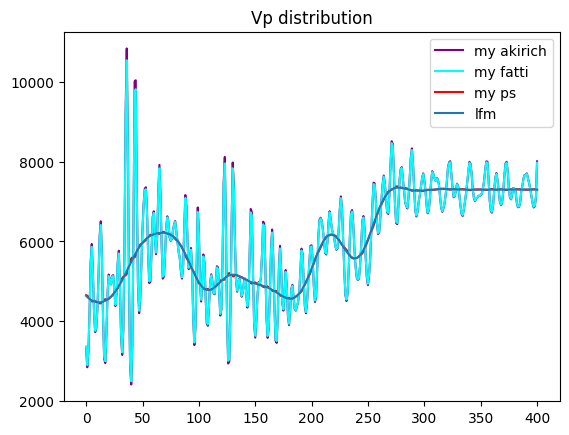

In [13]:
# res = np.exp(scipy.sparse.linalg.lsqr(avoop.T@avoop, avoop.T@seis[100, 100, :], x0 = model[100, 100, :], damp = 2e-2)[0])

res = np.exp(scipy.sparse.linalg.lsqr(avoop, seis[120, 50, :], x0 = model[120, 50, :], damp = 5e-1)[0])
res2 = np.exp(scipy.sparse.linalg.lsqr(avoop2, seis[120, 50, :], x0 = model[120, 50, :], damp = 3.5e-1)[0])
res3 = np.exp(scipy.sparse.linalg.lsqr(avoop3, seis[120, 50, :], x0 = model[120, 50, :], damp = 3.5e-1)[0])

# minv, dPP_res = pylops.avo.prestack.PrestackInversion(
#     seis[100, 100, :].reshape(sz, 4, order = "F"),
#     theta,
#     wavelets[0, :],
#     m0=model[100, 100, :].reshape(sz, 3, order = "F"),
#     linearization="akirich",
#     explicit=True,
#     epsI=np.hstack([4e-2*np.ones(sz), 4e-1*np.ones(sz), 8e-2*np.ones(sz)]),
#     returnres=True
# )
# minv2, dPP_res2 = pylops.avo.prestack.PrestackInversion(
#     seis[100, 100, :].reshape(sz, 4, order = "F"),
#     theta,
#     wavelets[0, :],
#     m0=model[100, 100, :].reshape(sz, 3, order = "F"),
#     linearization="fatti",
#     explicit=True,
#     epsI=np.hstack([8e0*np.ones(sz), 8e-1*np.ones(sz), 8e-2*np.ones(sz)]),
#     returnres=True
# )
# plt.plot(res[sz:2*sz])
# plt.plot(np.exp(minv[200:, 1]), "RED", lw=1, label="pylops")
# plt.plot(np.exp(minv2[200:, 1]), "blue", lw=1, label="pylops_fatti")
plt.plot(res2[0*sz+200:1*sz], "purple", label = "my akirich")
plt.plot(res[0*sz+200:1*sz], "aqua", label = "my fatti")
plt.plot(res3[0*sz+200:1*sz], "red", label = "my ps", zorder = 0)
plt.plot(np.exp(model[100, 100, 0*sz+200:1*sz]), label = "lfm")
plt.title("Vp distribution")
plt.legend()

In [14]:
for i in tqdm(range(stack_1.shape[0])):
    for j in range(stack_1.shape[0]):
        # res = np.exp(scipy.sparse.linalg.lsqr(avoop.T@avoop, avoop.T@seis[i, j, :], x0 = model[i, j, :], damp = 1e-2)[0])
        trace = np.exp(scipy.sparse.linalg.lsqr(avoop, seis[i, j, :], x0 = model[i, j, :], damp = 1.12e0)[0])
        trace2 = np.exp(scipy.sparse.linalg.lsqr(avoop2, seis[i, j, :], x0 = model[i, j, :], damp = 0.8e0)[0])
        trace3 = np.exp(scipy.sparse.linalg.lsqr(avoop3, seis[i, j, :], x0 = model[i, j, :], damp = 1e-1)[0])

        cube_vp[i, j, :] = trace[:sz]
        cube_vs[i, j, :] = trace[sz:2*sz]
        cube_rhob[i, j, :] = trace[2*sz:3*sz]

        cube_vp2[i, j, :] = trace2[:sz]
        cube_vs2[i, j, :] = trace2[sz:2*sz]
        cube_rhob2[i, j, :] = trace2[2*sz:3*sz]

        cube_vp3[i, j, :] = trace3[:sz]
        cube_vs3[i, j, :] = trace3[sz:2*sz]
        cube_rhob3[i, j, :] = trace3[2*sz:3*sz]
        

100%|██████████| 201/201 [01:13<00:00,  2.74it/s]


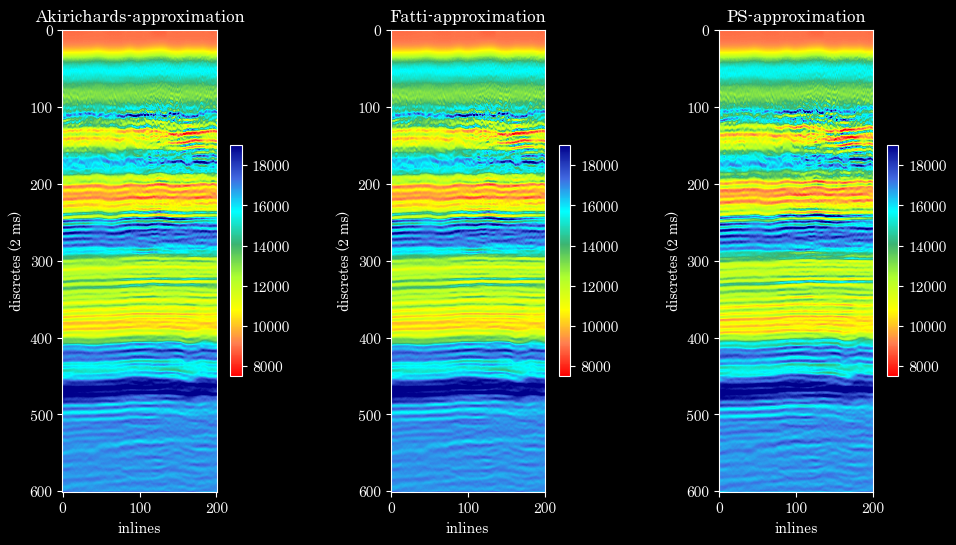

In [15]:
plt.style.use('dark_background')
plt.rcParams["font.family"] = "century"
colors = ["darkblue", "royalblue", "cyan", "mediumseagreen", "greenyellow", "yellow", "coral", "red"]
custom_discrete_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom_smooth_cmap", 
                                                                           colors[::-1])
plt.figure(figsize = (12, 6))
plt.subplot(131)
# plt.imshow(cube_vs[155, :, :].T, cmap = custom_discrete_cmap, clim = [2000, 4000])
plt.imshow(cube_rhob[:, 40, :].T * cube_vp[:, 40, :].T, cmap = custom_discrete_cmap, clim = [7500, 19000])
# plt.imshow((cube_rhob[:, 70, :].T * cube_vp[:, 70, :].T) - (cube_rhob2[:, 70, :].T * cube_vp2[:, 70, :].T), cmap = "magma", clim = [-500, 500])

# plt.imshow(cube_vs[0, :, :].T / cube_rhob[0, :, :].T, cmap = custom_discrete_cmap, clim = [1.7, 2])
plt.colorbar(shrink = .5)
plt.xlabel("inlines")
plt.ylabel("discretes (2 ms)")
plt.title("Akirichards-approximation")


plt.subplot(132)
# plt.imshow(stack_1[:, 40, :].T, cmap = "seismic", clim = [-4, 4])
plt.imshow(cube_rhob2[:, 40, :].T * cube_vp2[:, 40, :].T, cmap = custom_discrete_cmap, clim = [7500, 19000])
plt.colorbar(shrink = .5)
# plt.title("Near-angle \n stack")
plt.xlabel("inlines")
plt.ylabel("discretes (2 ms)")
plt.title("Fatti-approximation")

plt.subplot(133)
# plt.imshow(stack_1[:, 40, :].T, cmap = "seismic", clim = [-4, 4])
# plt.imshow((cube_rhob[:, 40, :].T * cube_vp[:, 40, :].T) - (cube_rhob2[:, 40, :].T * cube_vp2[:, 40, :].T), cmap = "Spectral", clim = [-100, 100])
plt.imshow(cube_rhob3[:, 40, :].T * cube_vp3[:, 40, :].T, cmap = custom_discrete_cmap, clim = [7500, 19000])
plt.colorbar(shrink = .5)
# plt.title("Near-angle \n stack")
plt.xlabel("inlines")
plt.ylabel("discretes (2 ms)")
plt.title("PS-approximation")

plt.show()

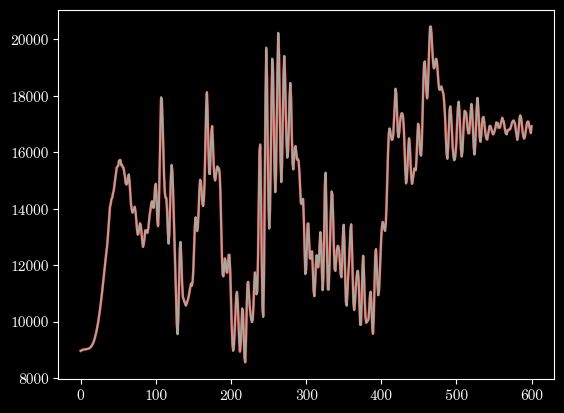

In [16]:
plt.plot(cube_rhob2[30, 70, :] * cube_vp2[30, 70, :], lw = 2, c = "red")
plt.plot(cube_rhob[30, 70, :] * cube_vp[30, 70, :], alpha = .8, zorder = 2)
plt.plot(np.exp(model[30, 70, :sz])*np.exp(model[30, 70, 2*sz:3*sz]), "black", zorder = 0)

In [17]:
import pyvista as pv


In [18]:
your_cube = cube_rhob[:, :, :] * cube_vp[:, :, :]

In [19]:
# Set global theme for the plotterpv.global_theme.background = 'white'
pv.global_theme.font.color = 'black'
pv.global_theme.font.size = 14
pv.global_theme.font.family = 'courier'
# Create a uniform grid for the data
grid = pv.UniformGrid()
# Set dimensions of the grid based on the shape of your_cube
grid.dimensions = np.array(your_cube.shape)
# Set the origin of the grid
grid.origin = (0, 0, 0)
# Set the spacing between grid points
grid.spacing = (25, 25, 25)
# Flatten your_cube and add it to the point data of the grid
grid.point_data["LFM"] = your_cube.flatten(order="F")
# Define scalar bar arguments for interactive colorbar
sargs = dict(interactive=True, title="Impedance", title_font_size=20)
# Create a plotter object
plotter = pv.Plotter(notebook=False)

# Add the mesh (your_cube) to the plotter with specified colormap and color range
plotter.add_mesh(your_cube, clim=[8000, 21000], cmap=custom_discrete_cmap, scalar_bar_args=sargs)
# Add scalar bar widget to interactively adjust clims
scalar_bar = plotter.add_scalar_bar(title="Impedance", n_labels=5, interactive=True)
# Show grid bounds with labels for each axis
plotter.show_bounds(xlabel='Inlines', ylabel='Crosslines', zlabel="Discretes")
# Display the plot
plotter.show()

c:\Users\Владислав\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyvista\plotting\renderer.py:1433: PyVistaDeprecationWarning: `xlabel` is deprecated. Use `xtitle` instead.
  warnings.warn(
c:\Users\Владислав\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyvista\plotting\renderer.py:1439: PyVistaDeprecationWarning: `ylabel` is deprecated. Use `ytitle` instead.
  warnings.warn(
c:\Users\Владислав\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyvista\plotting\renderer.py:1445: PyVistaDeprecationWarning: `zlabel` is deprecated. Use `ztitle` instead.
  warnings.warn(
